## 주식 예측 시스템 

## 라이브러리 및 시계열 데이터 준비(삼성전자)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/Samsung_E.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## 전처리(결측치 확인 및 보간, 로그화) 

시계열 데이터를 분석하기 전에 먼저 결측치를 확인해야 한다.

In [2]:
ts=ts.interpolate(method='time') #결측치가 있다면 보간
ts[ts.isna()]  # 결측 되어있는 값을 출력

Series([], Name: Close, dtype: float64)

## 통계치 시각화 함수 

In [3]:
def plot_rolling_statistics(timeseries, window = 12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

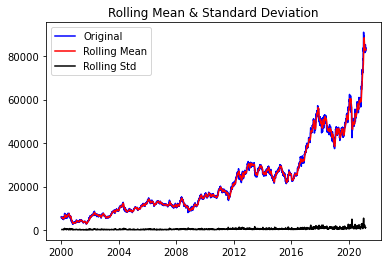

In [4]:
plot_rolling_statistics(ts, window=12)

시간의 추이의 따라 평균, 분산이 증가하는 패턴을 보이므로 안정적이지 않다.

시계열의 데이터의 안정성을 평가하기 위해 더욱 정량적인 방법을 사용하기로 한다.

## Stationary 검증 

Stationary, 안정성은 statsmodel 패키지에서 제공하는 adfuller 메소드를 사용할 수 있다.  

### Adfuller  
>Adfuller(Augmented Dickey-Fuller Test)는 주어진 시계열 데이터가 안정적이지 않다. 라는 귀무가설을 세우고 이 가설이 무너질 경우 시계열 데이터가 안정적이라는 결론을 내린다는 이념을 가진 테스트이다.  

여기서는 p-value 라는 값이 나오는데,  
### p-value  
>p-value는 어떤 귀무가설이 있을 때 이 귀무가설이 맞다고 가정했을 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률.  
0에 가까울수록 귀무가설은 부정되고 1에 가까울 수록 긍정된다.

In [5]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

아래 코드는 위에서 진행했던 정성적 그래프 분석법과 정량적 그래프 분석법을 이용한 코드이다.

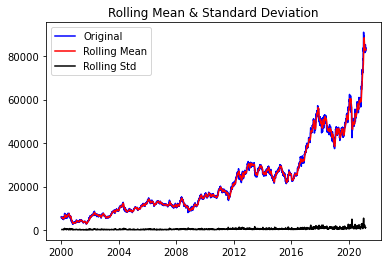

Results of Dickey-Fuller Test:
Test Statistic                    2.201606
p-value                           0.998884
#Lags Used                       26.000000
Number of Observations Used    5294.000000
Critical Value (1%)              -3.431586
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64


In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window = 12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)



p_value가 0.998로 stationary하지 않다.

시간 추이에 따라 분산이 점점 커지고 있기 때문에 이 때 도움되는 로그함수를 취해준다.

In [7]:
ts_log = np.log(ts) #시간 추이에 따라 분산이 점점 커지고 있는 경우 로그를 취해주는 것이 도움된다.

In [8]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.323791
p-value                           0.922067
#Lags Used                        4.000000
Number of Observations Used    5316.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


로그를 취해주었음에도 p_value 값이 0.07가량 정도밖에 줄어들지 않았다.

시계열 분석에서는 시간 추이에 따라 나타나는 평균값의 변화를 trend, 추세라고한다. 이 변화하는 추세를 상쇄 즉 변화량을 제거해 주려면 Moving Average(rolling mean)을 구해서 log를 취해준 ts값에서 빼주면 도움이 될 것이다.

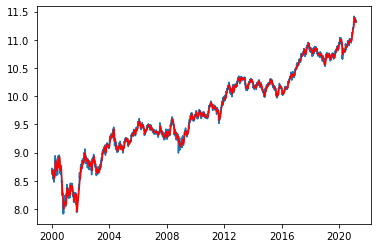

In [9]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [10]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-17         NaN
2000-01-18         NaN
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
Name: Close, dtype: float64

계산되지 않는 결측치는 제거해준다.

In [11]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057965
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
2000-02-01   -0.075802
2000-02-02   -0.076542
2000-02-03   -0.085232
2000-02-04   -0.072735
2000-02-07   -0.039679
2000-02-08    0.002573
Name: Close, dtype: float64

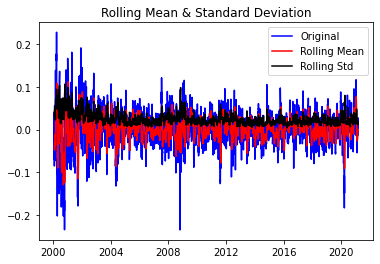

In [12]:
plot_rolling_statistics(ts_log_moving_avg)

In [13]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -1.665314e+01
p-value                        1.597634e-29
#Lags Used                     1.100000e+01
Number of Observations Used    5.298000e+03
Critical Value (1%)           -3.431585e+00
Critical Value (5%)           -2.862086e+00
Critical Value (10%)          -2.567060e+00
dtype: float64


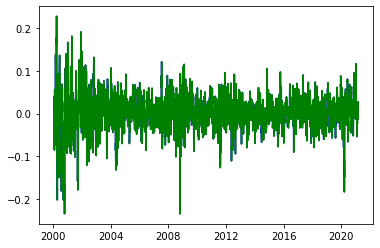

In [14]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

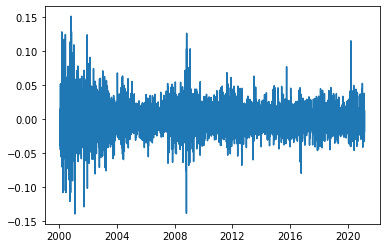

In [15]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

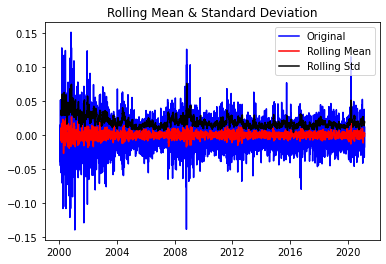

In [16]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [17]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -19.799381
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5275.000000
Critical Value (1%)              -3.431590
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


## 시계열 분해  
statsmodels의 seasonal_decompose메서드는 시계열안에서 trend와 seasonality를 분리할 수 있다.  
이 단계에서는 로그를 취한 ts로 수행해주어야 한다.

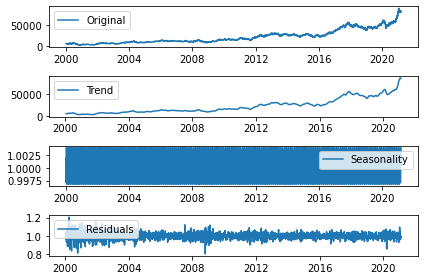

In [18]:
ts_log = np.log(ts)
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## residual 안정성 확인  
>원래의 시계열, Original 시계열에서 Trend와 Seansonality를 제거한 나머지는 Residual이다.  시계열 분해로 얻어진 residual로 예측 가능한 시계열을 얻을 수 있다.

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.729933e+01
p-value                        5.641364e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.257000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## Train, Test set 분리 

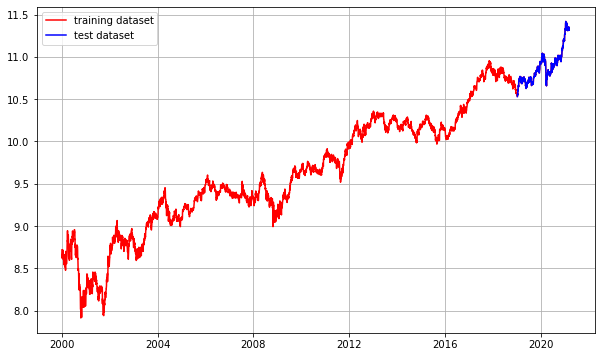

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## ARIMA parameter(p,q,d) 

### ARIMA  
>ARIMA 모델이란 자기회귀(AutoRregressive=AR),MA(Moving Average = MA),차분누적(I=Integration) 세가지 모델을 한 번에 고려하는 모델이다.  
자기회귀를 통해 주식을 본다면, 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측할 수 있고, MA를 통한다면 최근의 주식 성장세를 파악해 최근에 계속 하락세를 보이고 있으니 앞으로도 내릴 것이라는 예측을, 차분누적 I는 이전 데이터와 d차 차분의 누적의 합이다.  
위 셋은 각각 ARIMA모델에서 p, q, d 값으로 들어간다.

### ACF, PACF

> - ACF: 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수.  
> - PACF: 다른 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정  
<img src = "assets/E12_ARIMA_PQD.png">
[출처 : https://datascienceschool.net]  

ACF는 MA 모델의 시차(q), PACF는 AR 모델의 시차(p)를 결정할 수 있다.  
아래 두 그래프로 ARIMA 모델의 모수 p, q를 찾는데 도움을 줄 수 있다.  

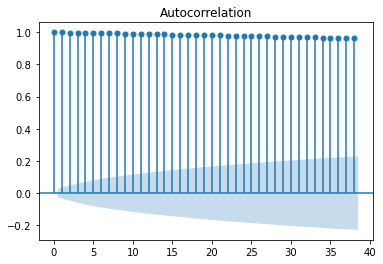

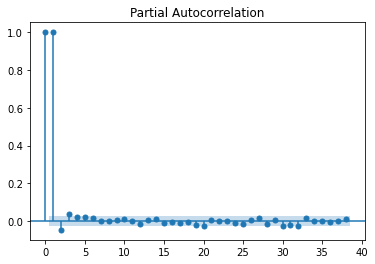

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


PACF는 2부터 0에 가까운 값 들을 나타내고 있다. 이는 그 시점부터 현재 데이터로부터 p 시점 떨어진 이전의 데이터는 상관이 없는 데이터이기 때문에, 고려할 필요가 없다는 뜻이다.  
ACF에서는 아주 미묘하게 감소하는 값을 보이기 때문에 적합한 값이 없다.

d를 구하기 위해서는 차분이 필요하다. 먼저 d차 차분을 진행한 뒤 해당 차분에서의 시계열이  
안정된 상태인지 확인해야 한다. 

Results of Dickey-Fuller Test:
Test Statistic                  -40.116434
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5316.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


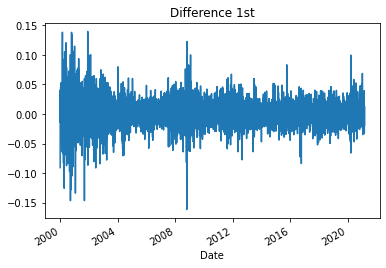

In [22]:
# # 1차 차분 구하기
# diff_1 = ts_log.diff(periods=1).iloc[1:]
# diff_1.plot(title='Difference 1st')
# In [7]:
# train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
# plt.figure(figsize=(10,6))
# plt.grid(True)

# augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                  -21.847998
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5285.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


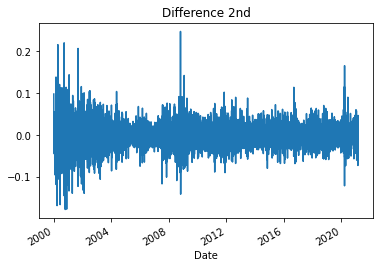

In [23]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 안정된 값이 나왔다. 두 값 중 아무거나 써도 상관 없을 것 같다.

## ARIMA 모델 훈련, 테스트 

In [24]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11282.237
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22558.473
Time:                        23:54:59   BIC                         -22539.052
Sample:                             1   HQIC                        -22551.651
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.093      0.275      -0.000       0.001
ar.L1.D.Close     0.0436      0.014      3.017      0.003       0.015       0.072
                                    Root

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

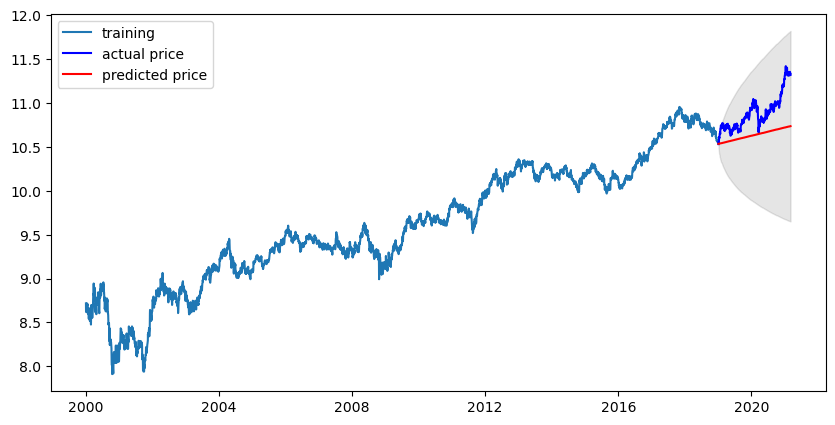

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  257635603.80197006
MAE:  12871.759288620011
RMSE:  16051.031237960073
MAPE: 21.50%


In [27]:
def do_predict(data,p,q,d):
    dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/'+data
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']

    ts=ts.interpolate(method='time') #결측치가 있다면 보간
    ts_log = np.log(ts)

# 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)

    from statsmodels.tsa.arima_model import ARIMA

    # Build Model
    model = ARIMA(train_data, order=(p, q, d))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import math

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))


## 카카오 주식 분석 

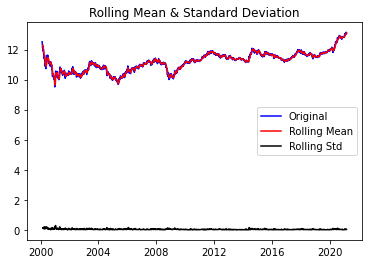

Results of Dickey-Fuller Test:
Test Statistic                   -1.247878
p-value                           0.652668
#Lags Used                        5.000000
Number of Observations Used    5283.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.790059e+01
p-value                        2.954390e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.225000e+03
Critical Value (1%)           -3.431602e+00
Critical Value (5%)           -2.862093e+00
Critical Value (10%)          -2.567065e+00
dtype: float64


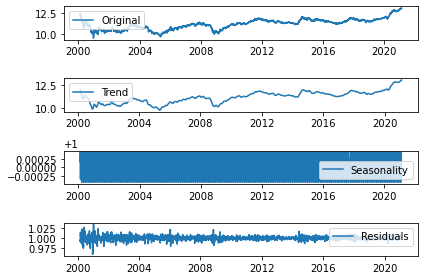

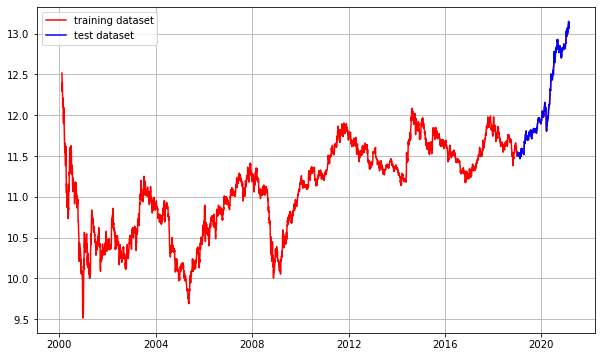

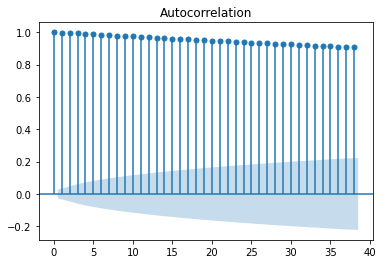

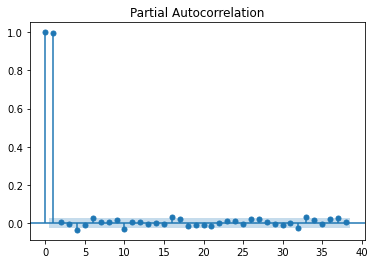

Results of Dickey-Fuller Test:
Test Statistic                  -32.342605
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5283.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -22.026427
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    5255.000000
Critical Value (1%)              -3.431595
Critical Value (5%)              -2.862090
Critical Value (10%)             -2.567063
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4759
Model:                 ARIMA(2, 1, 0)   Log Likelihood                9363.858
Method:                       css-mle   S.D. of innovations          

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

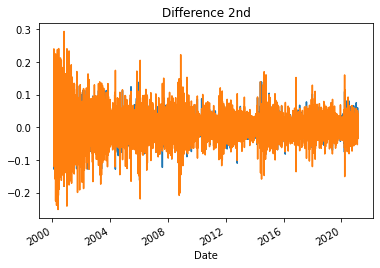

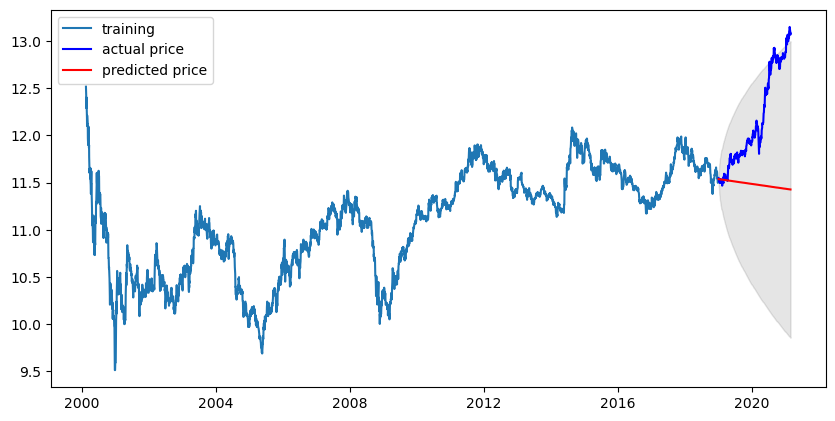

MSE:  29568700453.26796
MAE:  123643.79276102145
RMSE:  171955.51882178124
MAPE: 43.17%


In [28]:
do_predict('kakao.csv',2,1,0)

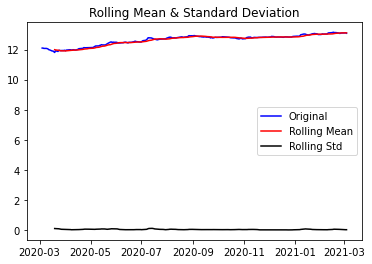

Results of Dickey-Fuller Test:
Test Statistic                  -0.999767
p-value                          0.753349
#Lags Used                       1.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.929522e+00
p-value                        2.399008e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


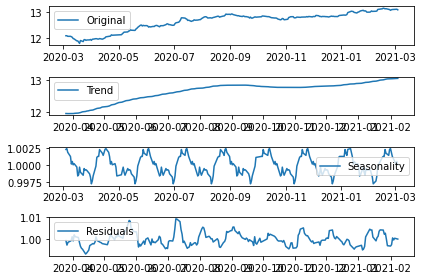

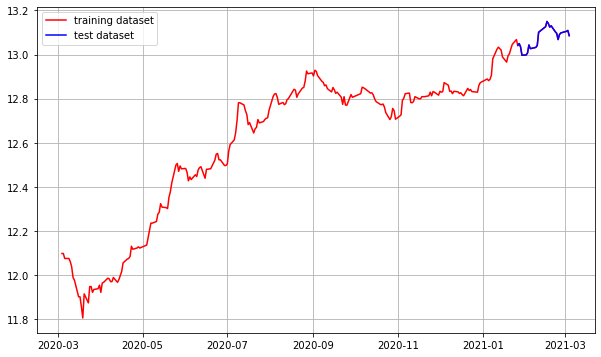

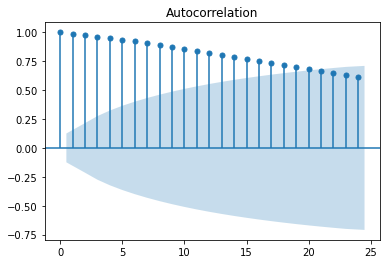

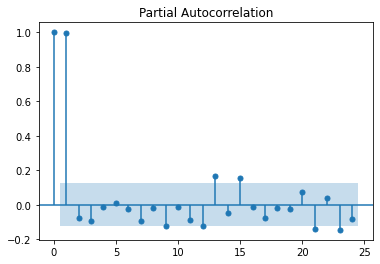

Results of Dickey-Fuller Test:
Test Statistic                -1.427594e+01
p-value                        1.349251e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.238517e+00
p-value                        1.911321e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 489.442
Method:                       css-mle   S.D. of innovat

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

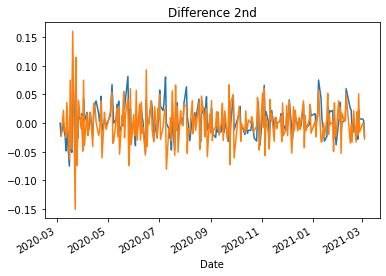

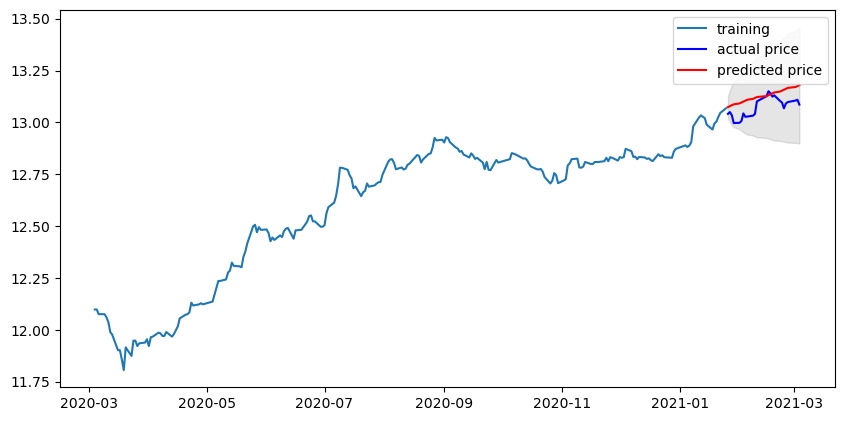

MSE:  926965992.0360391
MAE:  26893.446729303374
RMSE:  30446.116206111397
MAPE: 5.74%


In [29]:
do_predict('kakao_short.csv',1,1,0)

## LG Display 

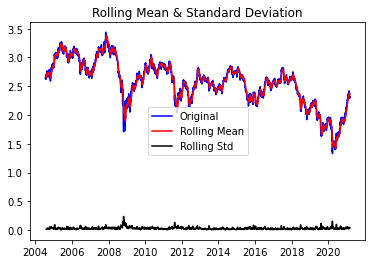

Results of Dickey-Fuller Test:
Test Statistic                   -2.210624
p-value                           0.202412
#Lags Used                       21.000000
Number of Observations Used    4161.000000
Critical Value (1%)              -3.431923
Critical Value (5%)              -2.862235
Critical Value (10%)             -2.567140
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.633057e+01
p-value                        3.063873e-29
#Lags Used                     3.100000e+01
Number of Observations Used    4.121000e+03
Critical Value (1%)           -3.431938e+00
Critical Value (5%)           -2.862242e+00
Critical Value (10%)          -2.567143e+00
dtype: float64


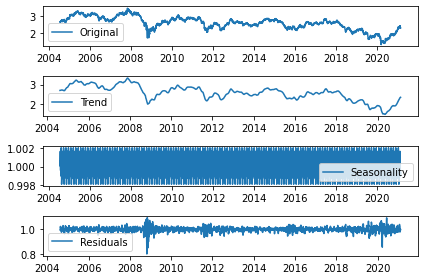

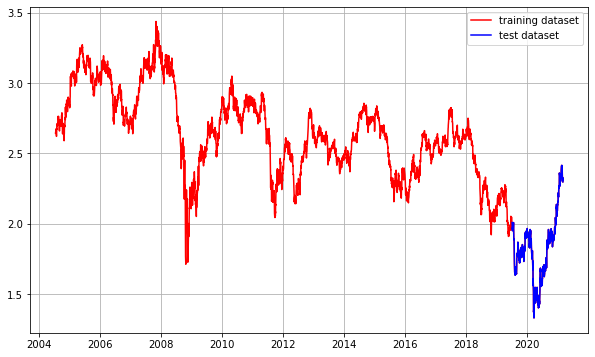

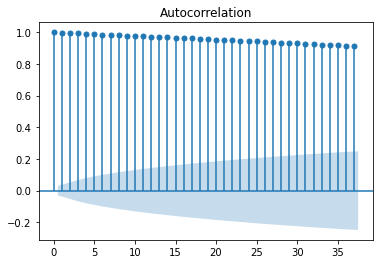

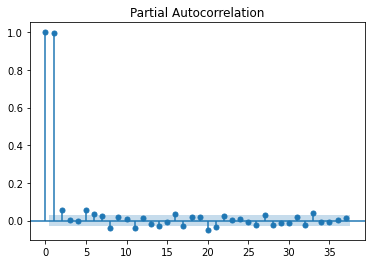

Results of Dickey-Fuller Test:
Test Statistic                -1.377840e+01
p-value                        9.395736e-26
#Lags Used                     2.000000e+01
Number of Observations Used    4.161000e+03
Critical Value (1%)           -3.431923e+00
Critical Value (5%)           -2.862235e+00
Critical Value (10%)          -2.567140e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -19.251619
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4149.000000
Critical Value (1%)              -3.431927
Critical Value (5%)              -2.862237
Critical Value (10%)             -2.567141
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3763
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8079.295
Method:                       css-mle   S.D. of innovations   

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

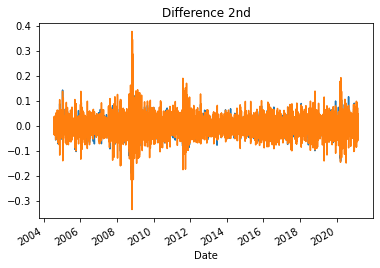

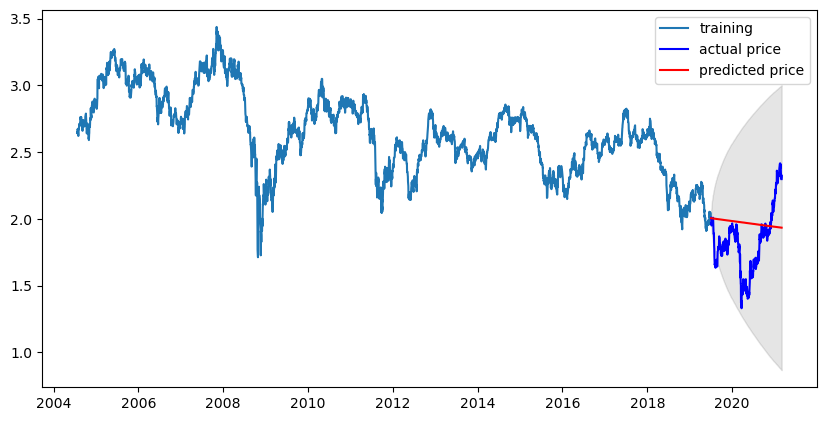

MSE:  3.291206463859903
MAE:  1.4974241632178036
RMSE:  1.8141682567666932
MAPE: 25.82%


In [30]:
do_predict('LGD.csv',2,1,0)

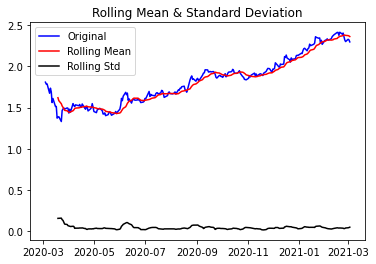

Results of Dickey-Fuller Test:
Test Statistic                  -0.202935
p-value                          0.938171
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.123646e+00
p-value                        8.733800e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


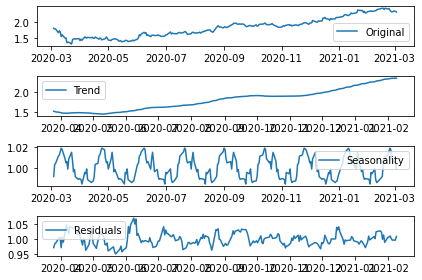

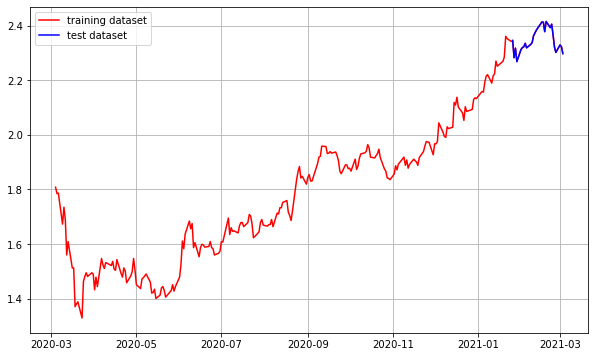

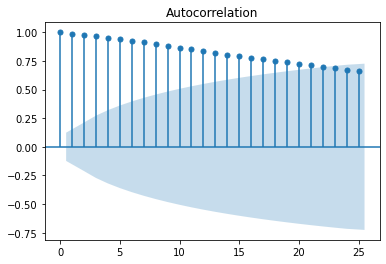

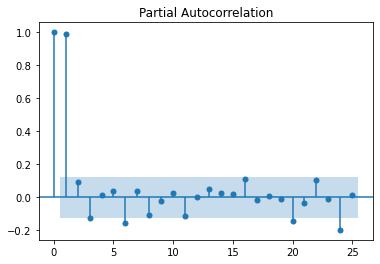

Results of Dickey-Fuller Test:
Test Statistic                -1.867669e+01
p-value                        2.043089e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.101887e+00
p-value                        1.293211e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 437.308
Method:                       css-mle   S.D. of innovat

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

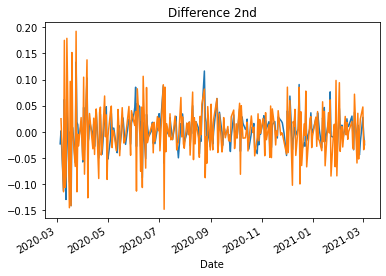

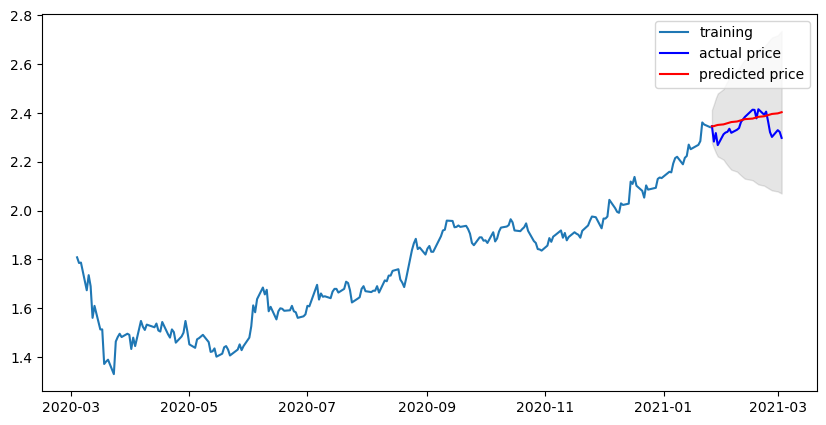

MSE:  0.2570922308953142
MAE:  0.40782736477772696
RMSE:  0.5070426322266346
MAPE: 3.99%


In [31]:
do_predict('LGD_short.csv',2,1,0)

## APPLE 

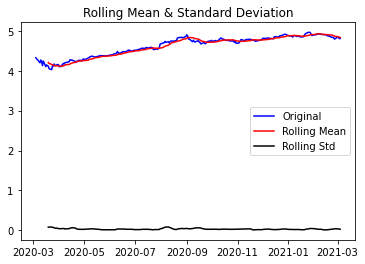

Results of Dickey-Fuller Test:
Test Statistic                  -1.089399
p-value                          0.719281
#Lags Used                       1.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.831253e+00
p-value                        3.970309e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


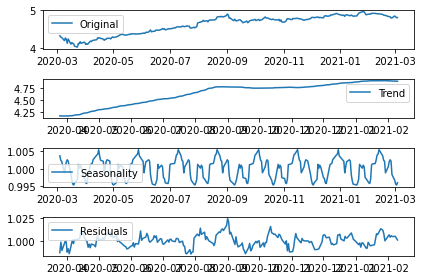

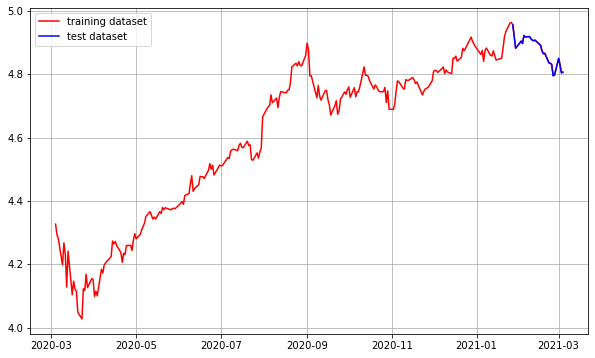

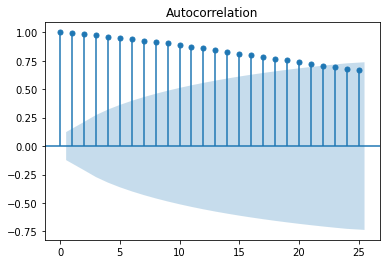

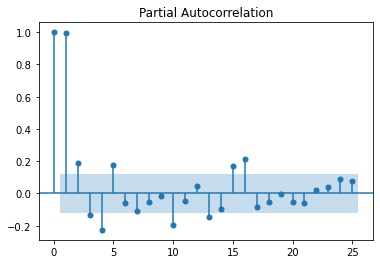

Results of Dickey-Fuller Test:
Test Statistic                 -20.322972
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.062406e+01
p-value                        5.422029e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 484.401
Method:                       css-mle   S.D. of innovations          

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

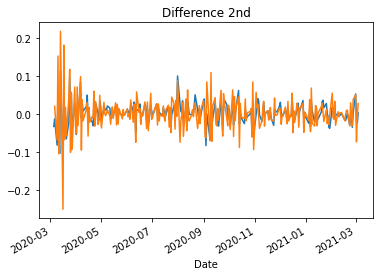

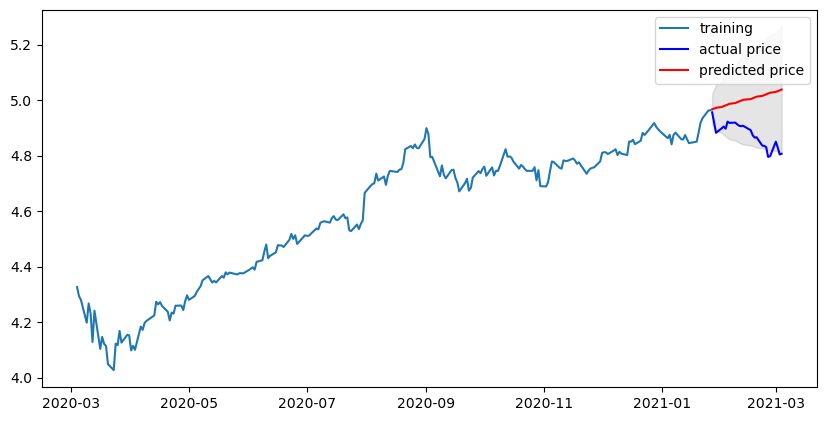

MSE:  392.949746380761
MAE:  17.79739066392363
RMSE:  19.822960081197788
MAPE: 13.90%


In [32]:
do_predict('apple_short.csv',1,1,0)

## NC Soft 

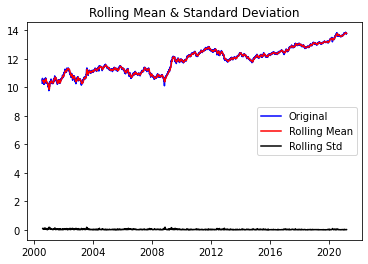

Results of Dickey-Fuller Test:
Test Statistic                   -0.668501
p-value                           0.854741
#Lags Used                       14.000000
Number of Observations Used    5170.000000
Critical Value (1%)              -3.431615
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.868693e+01
p-value                        2.040369e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.121000e+03
Critical Value (1%)           -3.431628e+00
Critical Value (5%)           -2.862105e+00
Critical Value (10%)          -2.567071e+00
dtype: float64


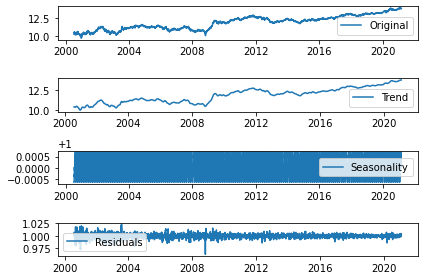

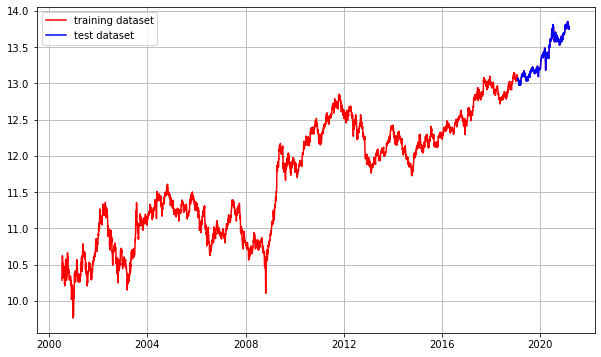

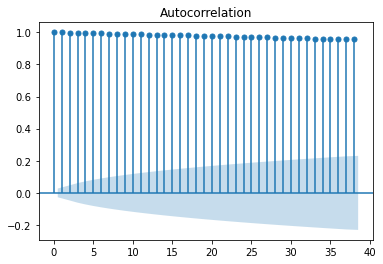

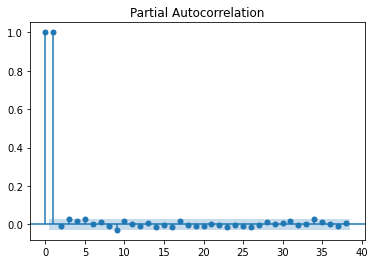

Results of Dickey-Fuller Test:
Test Statistic                  -19.696880
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    5170.000000
Critical Value (1%)              -3.431615
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -20.316065
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5149.000000
Critical Value (1%)              -3.431621
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4665
Model:                 ARIMA(2, 1, 0)   Log Likelihood                9416.861
Method:                       css-mle   S.D. of innovations          

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

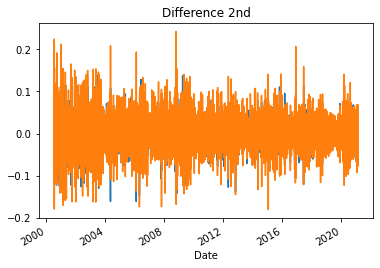

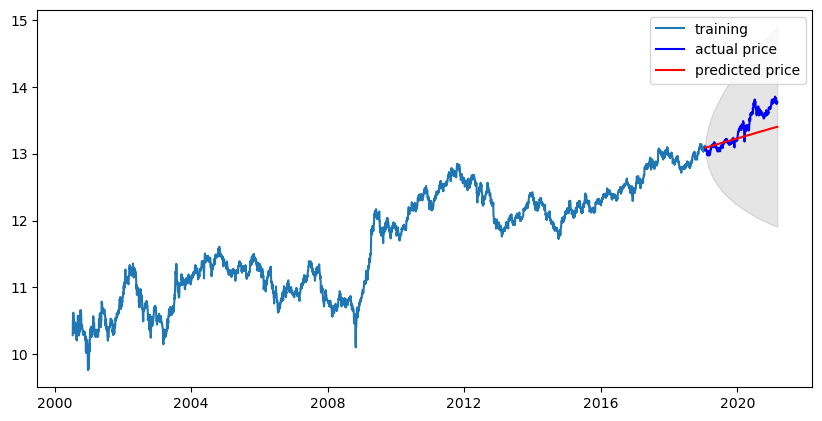

MSE:  25166384327.43742
MAE:  115170.10644446581
RMSE:  158639.16391432923
MAPE: 14.59%


In [33]:
do_predict('nc.csv',2,1,0)

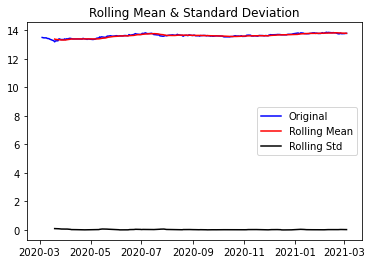

Results of Dickey-Fuller Test:
Test Statistic                  -1.369997
p-value                          0.596572
#Lags Used                       1.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.987983e+00
p-value                        1.773310e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


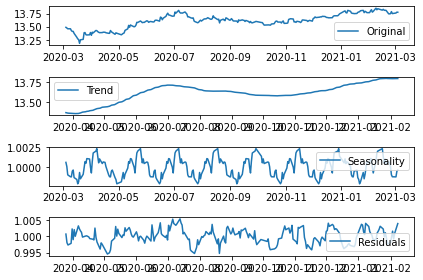

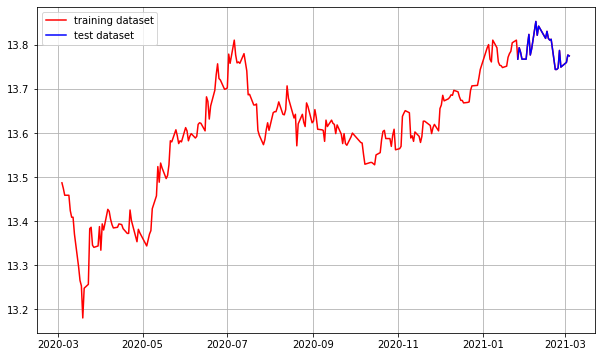

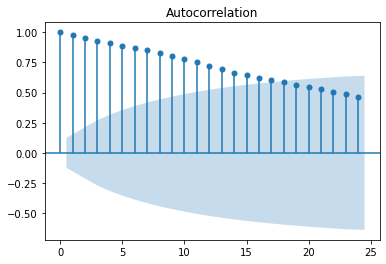

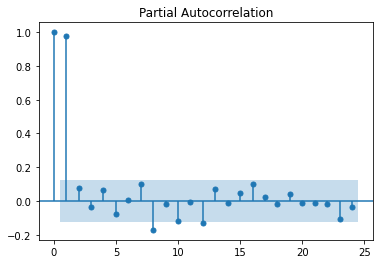

Results of Dickey-Fuller Test:
Test Statistic                -1.727713e+01
p-value                        5.812393e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.232647e+00
p-value                        1.662340e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 478.860
Method:                       css-mle   S.D. of innovat

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

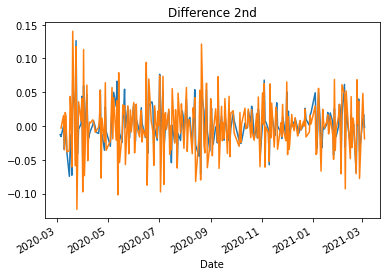

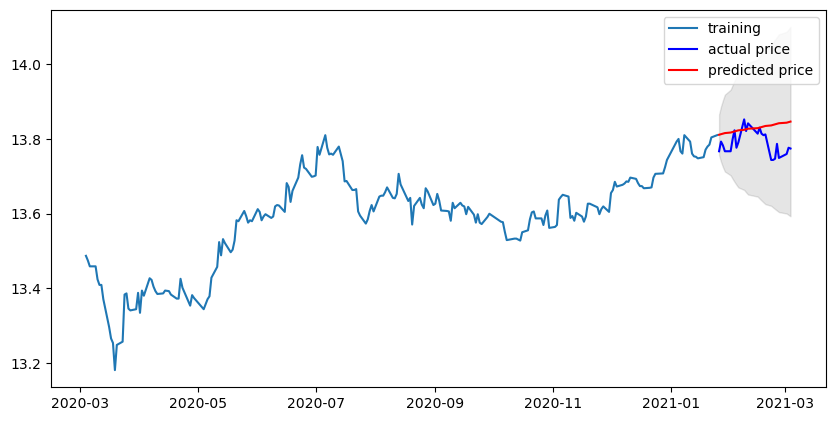

MSE:  2662550512.763319
MAE:  42276.69056572227
RMSE:  51599.908069330115
MAPE: 4.42%


In [35]:
do_predict('nc_short.csv',1,1,0)

## Samsung 

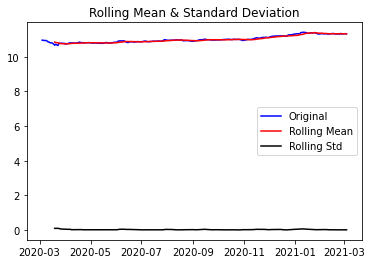

Results of Dickey-Fuller Test:
Test Statistic                  -0.120052
p-value                          0.947404
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.949797
p-value                          0.000028
#Lags Used                       0.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


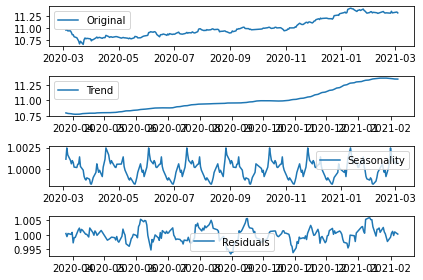

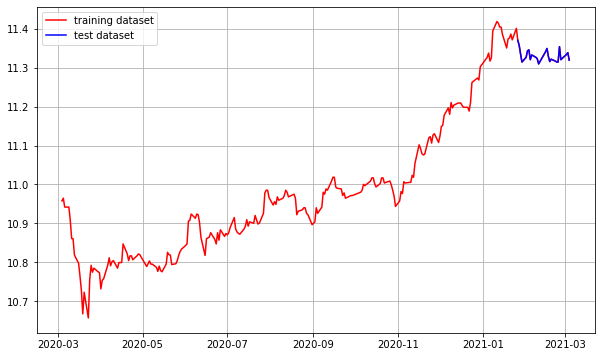

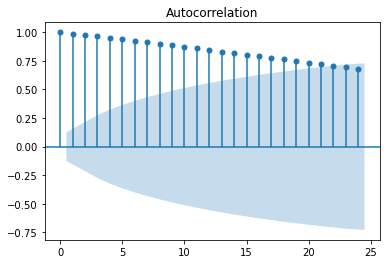

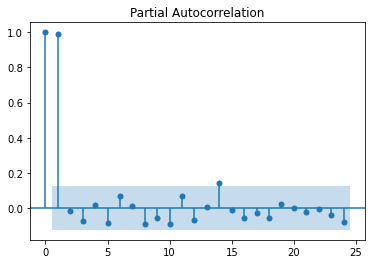

Results of Dickey-Fuller Test:
Test Statistic                -1.626852e+01
p-value                        3.507208e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.066674e+00
p-value                        5.059635e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 535.346
Method:                       css-mle   S.D. of innovat

/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

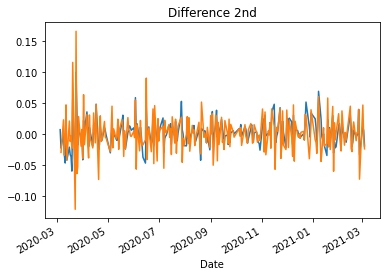

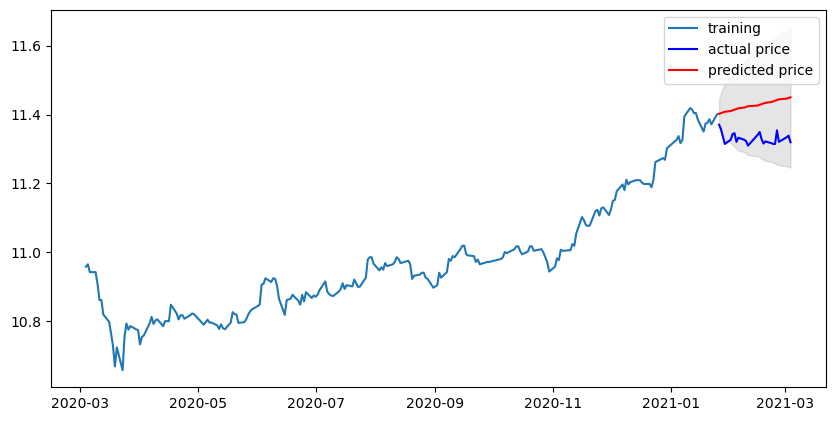

MSE:  73820177.38064274
MAE:  8318.447081801232
RMSE:  8591.866932200635
MAPE: 10.01%


In [34]:
do_predict('samsung_short.csv',1,1,0)

## 회고  
이번 프로젝트의 관건은 시계열의 안정성과 ARIMA 모델의 안정성이라고 생각했다.  
그래서 전처리 단계와 안정화 단계를 거쳤고 잘 진행했다고 생각했는데 의외로 MAPE 점수가 잘  
나오지 않았다. 진행을 하다가 혹여나 데이터가 문제있는게 아닐까 라는 생각으로 데이터를 잘라서 모델에 넣었는데 의외로 MAPE점수가 잘 나왔다. 시계열의 안정성과 데이터의 크기가 어떤 상관 관계를 가지고 있는지 잘 모르겠지만 확실히 예측성능에 영향을 준다는 것은 깨닳을 수 있었다.  
시계열 데이터라는 생각으로 두려움으로 시작했지만 생각보다 내용은 흥미로웠고 실생활에도  
굉장히 밀접한 프로젝트였다. 

## 루브릭  
> 1. 시계열의 안정성이 충분히 확인되었는가 ?  
p-value값이 충분했다.  

> 2. ARIMA 모델 모수선택 근거를 체계적으로 제시했는가?  
ACF와 PACF, d를 위한 차분을 제시했다.  

> 3. 예측 모델의 오차율이 기준이하로 정확하게 나왔는가?  
LGDisplay, NC, kakao에서 기준이하를 달성했다.